In [4]:
import tensorflow as tf
import numpy as np
import os
#畳み込み層の実装
def conv_layer(input_tensor,name,n_output_channels,ksize,padding='SAME',strides=[1,1,1,1]):
    with tf.variable_scope(name):
        n_input_channels=1
        
        weights_shape=(list(ksize)+[n_input_channels,n_output_channels])
        weights=tf.get_variable(name='_weights',shape=weights_shape)
        
        print(weights)
        
        biases=tf.get_variable(name='_biases',initializer=tf.zeros(shape=[n_output_channels]))
        
        print(biases)
        #重みと入力テンソルの掛け算
        conv=tf.nn.conv2d(input=input_tensor,filter=weights,strides=strides,padding=padding)
        print(conv)
        #重みと入力テンソルの積にバイアスを加える
        conv=tf.nn.bias_add(conv,biases,name='net_pre_activation')
        print(conv)
        #線形活性化
        conv=tf.nn.relu(conv,name='activation')
        print(conv)
        
        return conv        

In [5]:
"""batch学習をする時点でX_dataは一次元配列に変換されている"""
def batch_generator(X_train,y_train,batch_size=25,shuffle=True,random_state=None):
    X_data=np.array(X_train)
    y_data=np.array(y_train)
    idx=np.arange(y_data.shape[0])
    np.random.RandomState(random_state).shuffle(idx)
    
    X_data=X_data[idx]
    y_data=y_data[idx]
    
    for i in range(0,X_data.shape[0],batch_size):
        yield(X_data[i:i+batch_size,:],y_data[i:i+batch_size])

In [6]:
#全結合層の実装
def fc_layer(input_tensor,name,n_output_units,activation_fn=None):
    with tf.variable_scope(name):
        input_shape=input_tensor.get_shape().as_list()[1:]
        n_input_units=np.prod(input_shape)
        
        if len(input_shape)>1:
            input_tensor=tf.reshape(input_tensor,shape=(-1,n_input_units))
            
        weights_shape=[n_input_units,n_output_units]
        weights=tf.get_variable(name='__weights',shape=weights_shape)
        print(weights)
        
        biases=tf.get_variable(name='__biases',initializer=tf.zeros(shape=[n_output_units]))
        print(biases)
        #入力テンソルと重みの積の総和
        layer=tf.matmul(input_tensor,weights)
        print(layer)
        #バイアスが入る
        layer=tf.nn.bias_add(layer,biases,name='net_pre_activation')
        print(layer)
        
        if activation_fn is None:
            return layer
        layer=activation_fn(layer,name='activation')
        print(layer)
        return layer

In [7]:
#model構築
def build():
    #784のところは学習させる画像のピクセル数による
    #画像を学習させるときは一次元配列に直す必要性あり
    tf_x=tf.placeholder(tf.float32,shape=[None,32*32*3],name='tf_x')
    tf_y=tf.placeholder(tf.int32,shape=[None],name='tf_y')
    
    #入力テンソルはバッチ学習ができるように四次元テンソルにしておく
    tf_x_img=tf.reshape(tf_x,shape=[-1,32,32,3],name='tf_x_img')
    tf_y_onehot=tf.one_hot(indices=tf_y,depth=14,dtype=tf.float32,name='tf_y_onehot')
    
    #第一層
    print('==building 1st layer==')
    h1=conv_layer(tf_x_img,name='conv_1',n_output_channels=16,ksize=(6,6),padding='VALID')
    
    print('==h1 pooling==')
    h1_pool=tf.nn.max_pool(h1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #第二層
    print('==building 2nd layer==')
    h2=conv_layer(h1_pool,name='conv_2',n_output_channels=32,ksize=(6,6),padding='VALID')
    
    print('==h2 pooling==')
    h2_pool=tf.nn.max_pool(h2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #第三層
    print('==building 3rd layer==')
    h3=conv_layer(h2_pool,name='conv_3',n_output_channels=64,ksize=(4,4),padding='VALID')
    
    print('==h3 pooling==')
    h3_pool=tf.nn.max_pool(h3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #第四層
    h4=fc_layer(h3_pool,name='linear_4',n_output_units=1024,activation_fn=tf.nn.relu)
    
    #dropout
    keep_prob=tf.placeholder(tf.float32,name='tf_keep_prob')
    h4_drop=tf.nn.dropout(h3_pool,keep_prob=keep_prob,name='dropout_layer')
    
    #第五層
    #classの数がn_output_units 
    #class数はアーテイストの数による
    h5=fc_layer(h4_drop,name='linear_5',n_output_units=7,activation_fn=None)
    
    
    #予測とラベル
    predictions={'probabilities':tf.nn.softmax(h5,name='probabilities'),'labels':
                tf.cast(tf.argmax(h5,axis=1),tf.int32,name='labels')}
    
    #損失関数、コスト
    cost=tf.reduce_mean(tf.softmax_cross_entropy_with_logits(logits=h5,labels=tf_y_onehot),name=(cross_entropy_loss))
    
    #最適化
    optimizer=tf.train.AdamOptimizer(learning_rate)
    optimizer=optimizer.minimize(cost,name='train_op')
    
    #予測正解率を特定
    correct_predictions=tf.eqaul(predictions['labels'],tf_y,name='correct_pred')
    
    accuracy=tf.reduce_mean(tf.cast(correct_predictions,tf.float32),name='accuracy')
    
    

In [2]:
import os
import numpy as np
import tensorflow as tf
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

label_dict={'aoyama':0,'komazawa':1,'meigaku':2,'misaki':3,'obirin':4,'phoenix':5,'saidai':6
           ,'sekei':7,'senshu':8,'teikyo':9,'tokyo':10,'twu':11,'ycu':12,'ynu':13}

def load_data(data_type):
    #filename,image,labelを格納するリストを作成
    #画像とラベルを返す
    filenames=[]
    images=[]
    labels=[]
    
    #条件に一致する要素のみを抽出
    #faces directoryからdirectoryが何もない以外のものとtrain dataのみを抽出
    walk=filter(lambda x:not len(x[1]),os.walk(r'D:/faces/{}/'.format(data_type.strip())) )
    
    for root,dirs,files in walk:
        filenames+=['{}/{}'.format(root,path) for path in files if not path.startswith('.')]
    #ランダムなファイルネームを選択
    random.shuffle(filenames)
    images=[]
    for idx in range(len(filenames)):
        file=filenames[idx]
        image=cv2.imread(file,3)
        image=cv2.resize(image,(32,32))
        image=image.reshape((-1,32*32))
        images.append(image)
    #labelを作成
    for filename in filenames:
        label=np.zeros(14)
        filename=filename.split('/')[-2]
        filename=filename[:-4]
        for key,value in label_dict.items():
            if key in filename:
                label[value]=1.
        labels.append(list(label))
    images=np.array(images)
    labels=np.array(labels)

    return images,labels
X_train,y_train=load_data('train')
X_test,y_test=load_data('test')
X_train=X_train.reshape(-1,32,32,3).astype('float32')/255
X_test=X_test.reshape(-1,32,32,3).astype('float32')/255
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(807, 32, 32, 3)
(807, 14)
(217, 32, 32, 3)


Epoch 1/150
807/807 [==============================] - 3s 3ms/step - loss: 2.4167 - acc: 0.1177
Epoch 2/150
807/807 [==============================] - 2s 3ms/step - loss: 2.3938 - acc: 0.1152
Epoch 3/150
807/807 [==============================] - 2s 3ms/step - loss: 2.3865 - acc: 0.1450
Epoch 4/150
807/807 [==============================] - 2s 3ms/step - loss: 2.3708 - acc: 0.1437
Epoch 5/150
807/807 [==============================] - 2s 3ms/step - loss: 2.3618 - acc: 0.1462
Epoch 6/150
807/807 [==============================] - ETA: 0s - loss: 2.3466 - acc: 0.150 - 2s 3ms/step - loss: 2.3473 - acc: 0.1499
Epoch 7/150
807/807 [==============================] - 2s 2ms/step - loss: 2.3243 - acc: 0.1636
Epoch 8/150
807/807 [==============================] - 2s 3ms/step - loss: 2.3085 - acc: 0.1636
Epoch 9/150
807/807 [==============================] - 2s 3ms/step - loss: 2.2824 - acc: 0.1772
Epoch 10/150
807/807 [==============================] - 2s 3ms/step - loss: 2.2508 - acc: 0.1710
E

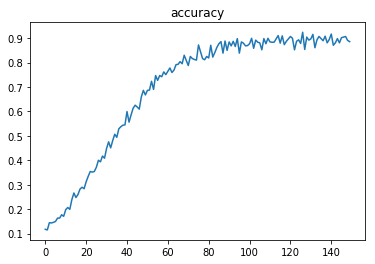

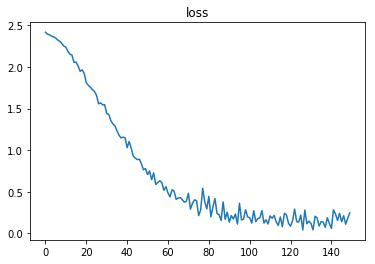

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
model=Sequential()
model.add(Conv2D(16,kernel_size=(5,5),activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(24,kernel_size=(4,4),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

#学習を実行
hist=model.fit(X_train,y_train,batch_size=32,epochs=150,verbose=1)

score=model.evaluate(X_test,y_test,verbose=1)
print('accuracy:',score[1],'loss:',score[0])
plt.figure()
plt.plot(hist.history['acc'])
plt.title('accuracy')
plt.show()

plt.figure()
plt.plot(hist.history['loss'])
plt.title('loss')
plt.show()
